In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

ADF Statistic: -1.2772564291958157
p-value: 0.6395122378192641


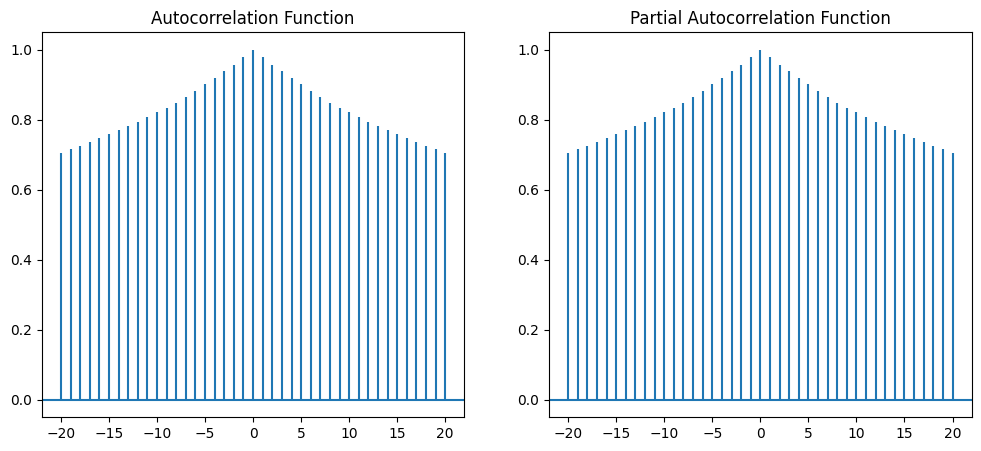

In [5]:
# Load the stock market data
file_path = "Download Data - STOCK_US_XNYS_AXP.csv"
stock_df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
stock_df['Date'] = pd.to_datetime(stock_df['Date'], format='%m/%d/%Y')

# Select relevant columns for analysis
features = ['Close', 'Open', 'High', 'Low', 'Volume']
stock_df = stock_df[['Date'] + features]

# Drop missing values (if any)
stock_df.dropna(inplace=True)

# Set 'Date' as the index for time series analysis
stock_df.set_index('Date', inplace=True)

# Perform ADF Test for stationarity
adf_result = adfuller(stock_df['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(121)
plt.acorr(stock_df['Close'] - stock_df['Close'].mean(), maxlags=20)
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.acorr(stock_df['Close'] - stock_df['Close'].mean(), maxlags=20)
plt.title('Partial Autocorrelation Function')
plt.show()



In [6]:

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(stock_df) * 0.8)
train, test = stock_df[:train_size], stock_df[train_size:]

# Train ARIMA model
arima_model = ARIMA(train['Close'], order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=len(test))

# Train SARIMA model
sarima_model = SARIMAX(train['Close'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.forecast(steps=len(test))

# Calculate performance metrics
arima_rmse = np.sqrt(mean_squared_error(test['Close'], arima_predictions))
sarima_rmse = np.sqrt(mean_squared_error(test['Close'], sarima_predictions))

arima_mae = mean_absolute_error(test['Close'], arima_predictions)
sarima_mae = mean_absolute_error(test['Close'], sarima_predictions)

arima_mape = mean_absolute_percentage_error(test['Close'], arima_predictions)
sarima_mape = mean_absolute_percentage_error(test['Close'], sarima_predictions)

# Calculate accuracies
arima_accuracy = 100 - (arima_mape * 100)
sarima_accuracy = 100 - (sarima_mape * 100)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

ARIMA - RMSE: 7.360935147252499, MAE: 5.760435826626061, MAPE: 0.02692451174282083, Accuracy: 97.30754882571792%
SARIMA - RMSE: 3.8021629881196644, MAE: 3.159498975709097, MAPE: 0.014424958914866745, Accuracy: 98.55750410851333%


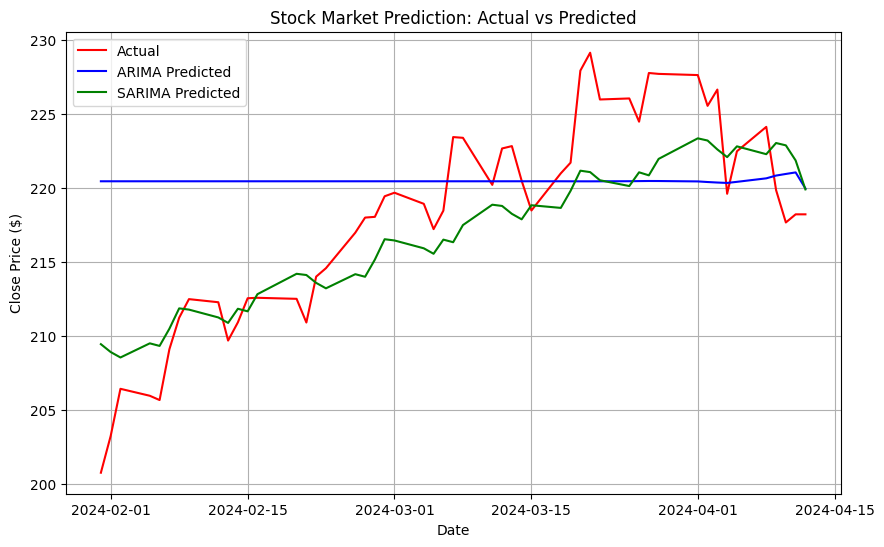

In [7]:

print(f'ARIMA - RMSE: {arima_rmse}, MAE: {arima_mae}, MAPE: {arima_mape}, Accuracy: {arima_accuracy}%')
print(f'SARIMA - RMSE: {sarima_rmse}, MAE: {sarima_mae}, MAPE: {sarima_mape}, Accuracy: {sarima_accuracy}%')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='red')
plt.plot(test.index, arima_predictions, label='ARIMA Predicted', color='blue')
plt.plot(test.index, sarima_predictions, label='SARIMA Predicted', color='green')
plt.title('Stock Market Prediction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
stock_df.tail(5)

,Close,Open,High,Low,Volume
Date,,,,,
2024-02-06,205.65,205.44,207.08,204.00,"3,255,282"
2024-02-05,205.94,205.49,206.72,203.42,"3,099,394"
2024-02-02,206.41,203.39,206.97,203.00,"3,393,186"
2024-02-01,203.22,200.36,203.47,199.88,"3,025,286"
2024-01-31,200.74,202.40,205.32,200.66,"3,495,246"


In [10]:
# Remove commas and convert to integer
stock_df['Volume'] = stock_df['Volume'].str.replace(',', '').astype(int)

In [11]:
stock_df['Volume'] = stock_df['Volume'].apply(lambda x: int(x))

In [21]:
def create_var_model(data, lags=1):
    model = VAR(data)
    results = model.fit(lags)
    return results

def main(stock_df):
    df = stock_df.copy()

    # Standardize the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    # Train the VAR model
    model_results = create_var_model(df_scaled)

    # Print model summary
    print(model_results.summary())

    # Make predictions
    lag_order = model_results.k_ar
    forecast = model_results.forecast(df_scaled.values[-lag_order:], steps=5)

    # Transform predictions back to original scale
    forecast_original = scaler.inverse_transform(forecast)

    # Create forecast DataFrame
    forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=5)
    forecast_df = pd.DataFrame(forecast_original, index=forecast_dates, columns=df.columns)

    print("\nForecast for next 5 days:")
    print(forecast_df)

    # Compute accuracy (if actual future values are available)
    actual_values = stock_df.iloc[-5:].values  # Assuming last 5 values are available for comparison
    mae = mean_absolute_error(actual_values, forecast_original)
    rmse = np.sqrt(mean_squared_error(actual_values, forecast_original))

    # Calculate MAPE
    mape = np.mean(np.abs((actual_values - forecast_original) / actual_values)) * 100
    accuracy = 100 - mape

    print(f"\nMean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")

    return forecast_df, accuracy

# Run the model
forecast_results, accuracy = main(stock_df)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, Feb, 2025
Time:                     18:44:53
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -23.3823
Nobs:                     251.000    HQIC:                  -23.6341
Log likelihood:           1236.59    FPE:                4.59427e-11
AIC:                     -23.8037    Det(Omega_mle):     4.08244e-11
--------------------------------------------------------------------
Results for equation Close
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.014469         0.003657           -3.956           0.000
L1.Close          0.035370         0.094092            0.376           0.707
L1.Open           1.218694         0.085164           14.310           0.000

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
